# Course: ICS 574
# Prject: Alchemists Project - EDA
- Date: May 6th 2024
- Project Members
    - ALGHAMDI, BANDAR, ID: 202206560
    - AHMED DHAFER ALQARNI, ID: 201453160
    - WALEED ABDULLAH ALFAIFI, ID: 201640920

The project is divided into 2 parts
1. Preprocessing the data
2. Model Experimentation (this includes model selection, validation, tuning, performance metrics for each model)

    2.1 Decision Tree Classifier Model

    2.2 Decision Tree Regressor Model

    2.3 GBTRegressor Model

    2.4 SGDRegressor Model

# Study Goal

The goal is to predict stocks performance in the energy and materials sectors, considering the stocks historical performance with changes in the prices of Brent oil and gold. This predictive analysis will help in understanding the market's behavior and could be a useful guide for making financial decisions.

# 1. Data Preprocessing

In [54]:
#import needed libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import seaborn as sns
import numpy as np
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# hide WRAN warnings for easier reading
import warnings
warnings.filterwarnings('ignore')

# Create a Spark session
spark = SparkSession.builder.appName("MarketAlchemists").getOrCreate()
spark


In [55]:
# Load the datasets as pandas DataFrames from existing excel files
stocks_df = pd.read_csv("./datasets/Tadawul_stcks.csv")
brent_df = pd.read_csv("./datasets/BrentOilPrices.csv")
gold_df = pd.read_csv("./datasets/Gold_Daily.csv")

# hide warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Preprocess the stock data as done in the EDA Part
# previously we have seen that the data is not clean and has missing values in Phase 1 of the project
# below code is to clean the data, rename the columns and merge the dataframes
# as done in the EDA Phase 1 part
stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
brent_df['Date'] = pd.to_datetime(brent_df['Date'])
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
brent_df = brent_df[['Date', 'Brent_Price']]
gold_df = gold_df[['Date', 'Gold_Price']]
stocks_specific_df.fillna(method='ffill', inplace=True)
stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')

# define a function that does all the above data preprocessing steps so we can use it before we try different models with original data
def preprocess_data(stocks_df, brent_df, gold_df):
    stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
    stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
    stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
    stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
    brent_df['Date'] = pd.to_datetime(brent_df['Date'])
    gold_df['Date'] = pd.to_datetime(gold_df['Date'])
    brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
    gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
    stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
    brent_df = brent_df[['Date', 'Brent_Price']]
    gold_df = gold_df[['Date', 'Gold_Price']]
    stocks_specific_df.fillna(method='ffill', inplace=True)
    stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
    stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')
    return stocks_brent_gold_df


In [56]:
# Create a Spark DataFrame
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [57]:
# print dataframe to check if it is created successfully
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E8|    4576.0|      51.29|    1690.5|
|  2380|Rabigh Refining a...|   PETRO RABIGH|   Energy|

In [58]:
# print features of the dataframe
stocks_brent_gold_df_spark.printSchema()

root
 |-- symbol: long (nullable = true)
 |-- name: string (nullable = true)
 |-- trading_name : string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- Stock_Price: double (nullable = true)
 |-- change: double (nullable = true)
 |-- perc_Change: double (nullable = true)
 |-- volume_traded : double (nullable = true)
 |-- value_traded: double (nullable = true)
 |-- no_trades : double (nullable = true)
 |-- Brent_Price: double (nullable = true)
 |-- Gold_Price: double (nullable = true)



# 2. Model Selection

In this section, we cover the usage of various models to identify the best option to go with: Decision Tree, Regression Tree, SVM

# 2.1 Model Selection: Decision Tree Model

Purpose: To predict categorical outcomes of stock price movement (increase or decrease) based on historical data.

Features: Uses various features including stock prices, Brent oil prices, and gold prices.

Methodology: The model uses a decision tree algorithm to classify stock price movements.

In [59]:
# adding a new Price_Change column to the DataFrame, since the label should be categorical in Decision Trees and later indexed
# this column will be used to determine if the stock price increased or decreased from the previous day
# create a new colum checking the "change" column; if it's greater than 0, it's an increase, otherwise it's a decrease
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("change") > 0, "1")
                        .otherwise("0"))


# Convert Price_Change to a numerical label
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/05/06 21:35:12 WARN TaskSetManager: Stage 322339 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [60]:
# view the dataframe for Saudi Basic Industries Corporation (SABIC) to check if the new column is added
stocks_brent_gold_df_spark.filter(F.col("symbol") == "2010").show(100)


+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+
|symbol|                name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|
+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+
|  2010|Saudi Basic Indus...|        SABIC|Materials|2020-01-23 00:00:00| 91.7| 91.7| 90.2|       90.9|  -0.9|      -0.98|     1589177.0| 1.444986769E8|    3737.0|      61.26|    1608.3|           0|  0.0|
|  2010|Saudi Basic Indus...|        SABIC|Materials|2020-01-22 00:00:00| 92.0| 92.3| 91.8|       91.8|  -0.2|      -0.22|      864850.0|  7.96494069E7|    2065.0|      62.11| 

In [61]:
# Create StringIndexers for categorical columns
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")

# create StringIndexers for the categorical columns and add them to the dataframe
stocks_brent_gold_df_spark = name_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = sector_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/05/06 21:35:21 WARN TaskSetManager: Stage 322343 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:35:21 WARN TaskSetManager: Stage 322346 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [62]:
# print the dataframe to check if the new columns are added
stocks_brent_gold_df_spark.show(10)

+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|symbol|                name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|
+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|  2030|Saudi Arabia Refi...|        SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|
|  2222|Saudi Arabian Oil...| SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.

In [63]:
# extract date only from the Date column to use it as a feature in a new column
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Date", F.to_date(F.col("Date")))

In [64]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|symbol|                name|  trading_name |   Sector|      Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|
+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05|33.05| 33.2|32.95|       33.0| -0.05|      -0.15| 

In [65]:
# transform Date to datetype
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Date", F.to_date(F.col("Date")))
# create a new column with the year of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Year", F.year(F.col("Date")))
# create a new column with the month of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Month", F.month(F.col("Date")))
# create a new column with the day of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Day", F.dayofmonth(F.col("Date")))

In [66]:
# print dataframe to check if the new columns are added
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+----+-----+---+
|symbol|                name|  trading_name |   Sector|      Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|Year|Month|Day|
+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+----+-----+---+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|2020|    3|  5|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2

In [67]:
# Create a VectorAssembler for the features selected
assembler = VectorAssembler(inputCols=["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price", "Year", "Month", "Day"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)

In [74]:
# Train-test split
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]

In [75]:
# Define the DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=47)
model = dt.fit(train) # Train the model on the training data

24/05/06 21:36:28 WARN TaskSetManager: Stage 322396 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:28 WARN TaskSetManager: Stage 322397 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:28 WARN TaskSetManager: Stage 322399 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:28 WARN TaskSetManager: Stage 322401 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:28 WARN TaskSetManager: Stage 322403 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:28 WARN TaskSetManager: Stage 322405 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:28 WARN TaskSetManager: Stage 322407 contains a task of very large size (1102 KiB). The maximum recommended t

In [76]:
# Make predictions on the test data
predictions = model.transform(test)

In [77]:
# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.571984983575786


24/05/06 21:36:32 WARN TaskSetManager: Stage 322409 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [78]:
# Evaluate the model using F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
print("F1:", accuracy)

24/05/06 21:36:35 WARN TaskSetManager: Stage 322411 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


F1: 0.4162809009098081


In [79]:
# create a table for the predictions and the actual labels for SABIC for dates after 2018
predictions.createOrReplaceTempView("predictions")
sabic_predictions = spark.sql("SELECT name, Date, Stock_Price, Brent_Price, Gold_Price, label, prediction FROM predictions WHERE name = 'Saudi Basic Industries Corp.' AND Date > '2018-01-01'").show(500)


+--------------------+-------------------+-----------+-----------+----------+-----+----------+
|                name|               Date|Stock_Price|Brent_Price|Gold_Price|label|prediction|
+--------------------+-------------------+-----------+-----------+----------+-----+----------+
|Saudi Basic Indus...|2019-04-15 00:00:00|      125.0|       70.9|    1342.4|  1.0|       0.0|
|Saudi Basic Indus...|2019-05-06 00:00:00|      120.0|      71.95|    1334.0|  0.0|       0.0|
|Saudi Basic Indus...|2019-05-20 00:00:00|      109.2|      73.21|    1324.2|  0.0|       0.0|
|Saudi Basic Indus...|2019-05-23 00:00:00|      109.6|      68.37|    1331.8|  0.0|       0.0|
|Saudi Basic Indus...|2019-05-30 00:00:00|      111.8|      69.55|    1341.4|  1.0|       0.0|
|Saudi Basic Indus...|2019-06-12 00:00:00|      120.8|      61.66|    1381.2|  1.0|       0.0|
|Saudi Basic Indus...|2019-06-19 00:00:00|      118.8|      62.85|    1391.2|  0.0|       0.0|
|Saudi Basic Indus...|2019-06-24 00:00:00|      11

24/05/06 21:36:40 WARN TaskSetManager: Stage 322414 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:36:40 WARN TaskSetManager: Stage 322415 contains a task of very large size (1100 KiB). The maximum recommended task size is 1000 KiB.


In [80]:
# print the feature importances in a more readable way
feature_importances = model.featureImportances.toArray()
feature_names = ["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price", "Year", "Month", "Day"]
for i in range(len(feature_importances)):
    print(feature_names[i], ":", feature_importances[i])

nameIndex : 0.010939455988346551
SectorIndex : 0.0
Stock_Price : 0.2833437900441742
Brent_Price : 0.017164389528934117
Gold_Price : 0.6885523644385452


In [82]:
# print the hyperparameters of the model
print("Max Depth:", model._java_obj.getMaxDepth())
print("Max Bins:", model._java_obj.getMaxBins())
# print iteration number
print("Number of nodes:", model.numNodes)

Max Depth: 5
Max Bins: 47
Number of nodes: 11


In [83]:
# redo the same steps with the original data without the Dates
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("change") > 0, "1")
                        .otherwise("0"))
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
stocks_brent_gold_df_spark = name_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = sector_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
assembler = VectorAssembler(inputCols=["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=47)
pipeline = Pipeline(stages=[name_indexer, sector_indexer, assembler, dt])
model = dt.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# print the feature importances in a more readable way
feature_importances = model.featureImportances.toArray()
print ("Features Importance")
feature_names = ["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price"]
for i in range(len(feature_importances)):
    print(feature_names[i], ":", feature_importances[i])


24/05/06 21:37:34 WARN TaskSetManager: Stage 322416 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:37:34 WARN TaskSetManager: Stage 322419 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:37:35 WARN TaskSetManager: Stage 322422 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:37:35 WARN TaskSetManager: Stage 322426 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:37:35 WARN TaskSetManager: Stage 322427 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:37:35 WARN TaskSetManager: Stage 322429 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:37:36 WARN TaskSetManager: Stage 322431 contains a task of very large size (1102 KiB). The maximum recommended t

Accuracy: 0.5750736015701668
Features Importance
nameIndex : 0.0
SectorIndex : 0.0
Stock_Price : 0.29444456385629947
Brent_Price : 0.0
Gold_Price : 0.7055554361437005


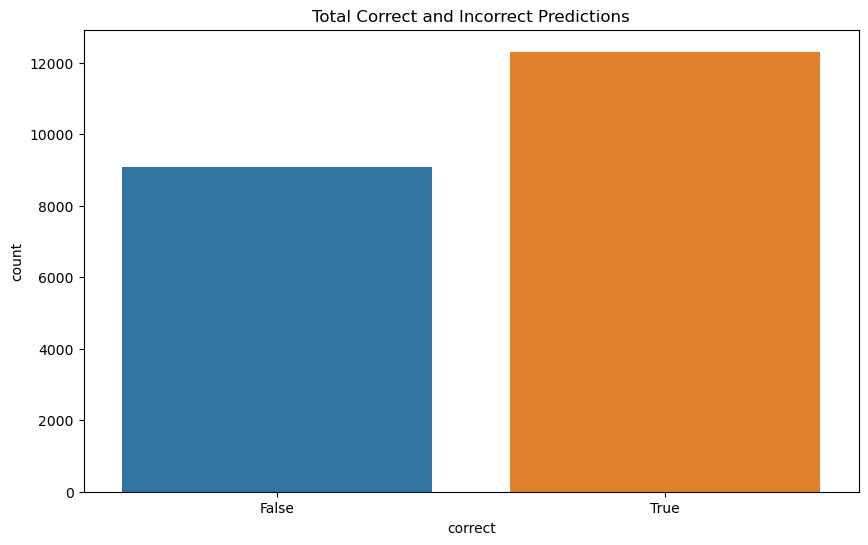

In [92]:
# plot total correct predictions and total incorrect predictions
predictions['correct'] = predictions['label'] == predictions['prediction']
correct_predictions = predictions[predictions['correct'] == True]
incorrect_predictions = predictions[predictions['correct'] == False]
plt.figure(figsize=(10, 6))
sns.countplot(x='correct', data=predictions)
plt.title("Total Correct and Incorrect Predictions")
plt.show()

# 2.2 Model Selection: Decision Tree Regression Model

Purpose: To predict continuous values of stock prices.

Features: Similar feature set including stock prices, market variables, and possibly lagged features for time series forecasting.

Methodology: Employs decision trees for regression, focusing on predicting exact stock price values.

In [93]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [94]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
indexer = StringIndexer(inputCol="name", outputCol="StockIndex")
indexed = indexer.fit(indexed).transform(indexed)

24/05/06 21:42:05 WARN TaskSetManager: Stage 322443 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:05 WARN TaskSetManager: Stage 322446 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [95]:
# verify the indexing
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|      18.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E

In [96]:
# create a feature vector by combining the features that we are going to use
vectorAssembler = VectorAssembler(inputCols=["Stock_Price", "volume_traded ", "value_traded", "no_trades ", "Brent_Price", "Gold_Price"], outputCol="features")

In [97]:
# Create a VectorAssembler for the features
stocks_brent_gold_df_spark = vectorAssembler.transform(indexed)

In [98]:
# show the datframe to verify features column
stocks_brent_gold_df_spark.show(truncate=False)

+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|symbol|name                                          |trading_name   |Sector   |Date               |open |high |low  |Stock_Price|change|perc_Change|volume_traded |value_traded  |no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|features                                           |
+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|2030  |Saudi Arabia Refineries Co.                   |SARCO          |Energy   |2020-03-05 00:00:00|35.55|35.85|34.9 |34.9       

In [99]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])


In [100]:
# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

In [101]:
# define the evaluator
# note the metricName parameter is rmse, which stands for Root Mean Squared Error. This is the default metric for regression problems.
# Other metrics include r2 (R squared) and mae (Mean Absolute Error)
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")

In [102]:
# Define the grid of hyperparameters
# We will use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for dt.maxDepth and 5 values for dt.maxBins, this grid will have 3 x 5 = 15 parameter settings for CrossValidator to choose from.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3, 4, 5, 6, 7, 8, 9, 10]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
    .build()

In [103]:
# Define the CrossValidator
# We will use a CrossValidator to select the best model.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [104]:
# fit the cv model with the assembled data
cvModel = cv.fit(stocks_brent_gold_df_spark)

24/05/06 21:42:28 WARN TaskSetManager: Stage 322451 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:28 WARN TaskSetManager: Stage 322453 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:28 WARN TaskSetManager: Stage 322454 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:28 WARN TaskSetManager: Stage 322456 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:28 WARN TaskSetManager: Stage 322458 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:28 WARN TaskSetManager: Stage 322460 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:42:28 WARN TaskSetManager: Stage 322461 contains a task of very large size (1102 KiB). The maximum recommended t

In [105]:
# get the average cross-validated RMSE
avg_rmse = np.mean(cvModel.avgMetrics)
print("Average RMSE: ", avg_rmse)

Average RMSE:  9.582906979079782


In [107]:
# print the hyperparameters of the best model
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())
# print iteration number
print(cvModel.bestModel.numNodes)

10
80
1667


In [108]:
# print the RMSE of all the models, just to view the difference in the cross-validated RMSE
for rmse in cvModel.avgMetrics:
    print(rmse)

10.523506450344849
10.524224711467607
10.521164976854774
10.518498072922254
10.516957125036999
10.143772817459263
10.127399671772977
10.084115689160864
10.068358329663274
10.071471431831172
9.942520053659916
9.927447833270843
9.841039882913456
9.81835476100735
9.823837167556869
9.739331849156118
9.725167504168738
9.63871393325778
9.608641048041118
9.605482362732673
9.601230212375514
9.551785826891543
9.470544631266034
9.446627701396528
9.448676124005923
9.475169018991163
9.41509330249192
9.324558691413035
9.306534917744031
9.310017547855209
9.346380873089341
9.269734910626854
9.167842563147534
9.156012347305246
9.156617590319545
9.233739659157834
9.112895384112296
9.025822882104492
8.981313628030907
8.98606125085255
9.111228027208792
8.982765675082884
8.89089061598243
8.834835001252044
8.854430003607721


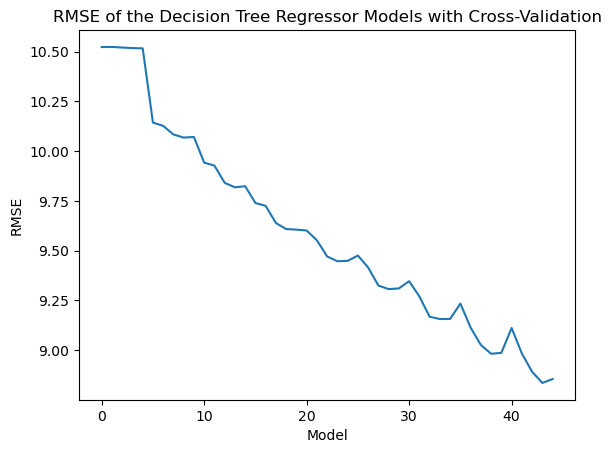

In [109]:
# plot all the RMSE values of the models to see the difference in the cross-validated RMSE
plt.plot(cvModel.avgMetrics)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of the Decision Tree Regressor Models with Cross-Validation')
plt.show()

In [110]:
# print the feature importances
feature_importances = cvModel.bestModel.featureImportances
feature_importances_df = pd.DataFrame(list(zip(stocks_brent_gold_df_spark.columns[2:], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)

         Feature  Importance
0  trading_name     0.444679
5            low    0.282833
3           open    0.106277
4           high    0.078810
1         Sector    0.050366
2           Date    0.037034


In [117]:
# print the hyperparameters of the best model
# The hyperparameters of the best model can provide insights into the configuration that yielded the best performance.
# Understanding the hyperparameters can help you tune future models and optimize their performance.
# The hyperparameters of the best model can guide further experimentation and refinement of the model.
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())
# print iteration number
print(cvModel.bestModel.numNodes)

10
80
1667


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2020-01-23 00:00:00|       90.9| 6.517571884984026|
|2020-01-22 00:00:00|       91.8| 4.947040498442368|
|2020-01-21 00:00:00|       92.0|12.139896373056995|
|2020-01-20 00:00:00|       92.9| 4.947040498442368|
|2020-01-16 00:00:00|       92.8|12.139896373056995|
|2020-01-15 00:00:00|       92.4|12.139896373056995|
|2020-01-14 00:00:00|       93.2| 6.517571884984026|
|2020-01-13 00:00:00|       92.7| 6.517571884984026|
|2020-01-09 00:00:00|       92.0| 6.517571884984026|
|2020-01-08 00:00:00|       90.5| 6.517571884984026|
|2020-01-07 00:00:00|       91.0| 6.517571884984026|
|2020-01-06 00:00:00|       91.9| 6.517571884984026|
|2020-01-02 00:00:00|       93.4| 6.517571884984026|
|2020-01-01 00:00:00|       93.1| 6.517571884984026|
|2019-12-31 00:00:00|       93.9| 6.517571884984026|
|2019-12-30 00:00:00|       93.7| 6.5175718849

24/05/06 21:45:18 WARN TaskSetManager: Stage 326536 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:18 WARN TaskSetManager: Stage 326537 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


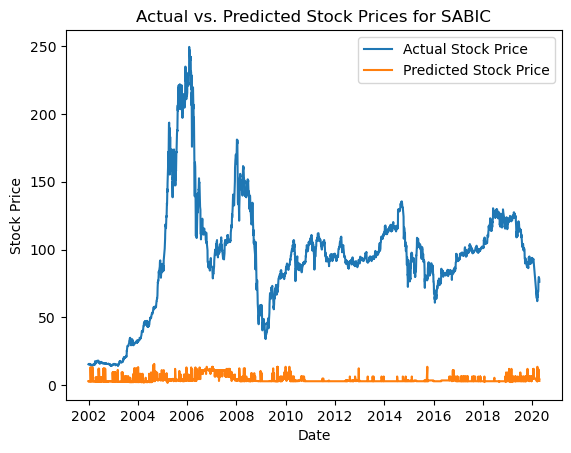

In [112]:
# create a table for SABIC actual and predicted stock prices

# get the predictions
predictions = cvModel.transform(stocks_brent_gold_df_spark)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show()

# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- we notice that the DecisionTreeRegressor model is not performing well; this can be due to the fact that the cross-validation is not respecting the time in the time-series data

- we can try to use the test:train split method instead of cross-validation to verify if it yeilds better results

In [113]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model = dt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/05/06 21:45:25 WARN TaskSetManager: Stage 326539 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:25 WARN TaskSetManager: Stage 326540 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:25 WARN TaskSetManager: Stage 326542 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:25 WARN TaskSetManager: Stage 326544 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:25 WARN TaskSetManager: Stage 326546 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:25 WARN TaskSetManager: Stage 326548 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:25 WARN TaskSetManager: Stage 326550 contains a task of very large size (1102 KiB). The maximum recommended t

Root Mean Squared Error (RMSE): 9.670282653702536


In [114]:
# we do non-random split to respect the time in the time-series data
# we split the data by date
# the training data is before 2018 and the testing data is after 2018
trainingData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date < '2018-01-01')
testData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date >= '2018-01-01')

# Define the DecisionTreeRegressor
dt2 = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model2 = dt.fit(trainingData2)

# Make predictions on the test data
predictions2 = model2.transform(testData2)

# Evaluate the model
evaluator2 = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions2)
print("Root Mean Squared Error (RMSE):", rmse2)

24/05/06 21:45:29 WARN TaskSetManager: Stage 326555 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:29 WARN TaskSetManager: Stage 326556 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:29 WARN TaskSetManager: Stage 326557 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:30 WARN TaskSetManager: Stage 326559 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:30 WARN TaskSetManager: Stage 326561 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:30 WARN TaskSetManager: Stage 326563 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:45:30 WARN TaskSetManager: Stage 326565 contains a task of very large size (1102 KiB). The maximum recommended t

Root Mean Squared Error (RMSE): 12.603706959218371


24/05/06 21:47:38 WARN TaskSetManager: Stage 326573 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:47:38 WARN TaskSetManager: Stage 326574 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


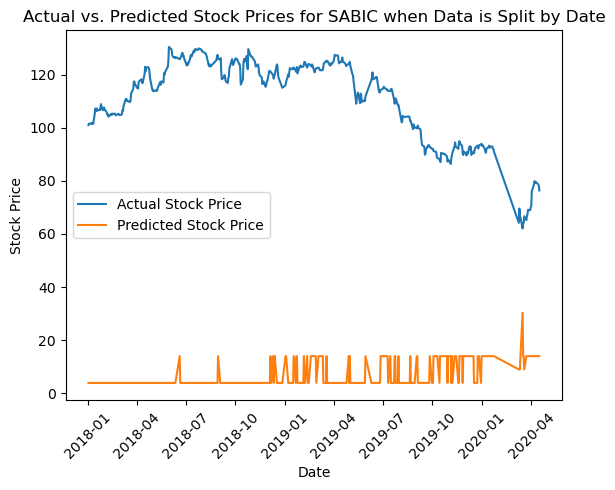

In [116]:
# plot the actual and predicted stock prices for SABIC when the data is split by date
sabic_predictions2 = predictions2.select("Date", "Stock_Price", "prediction").filter(predictions2.name == "Saudi Basic Industries Corp.")
sns.lineplot(data=sabic_predictions2.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions2.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC when Data is Split by Date")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.xticks(rotation=45)
plt.show()

- from above, we see normal use of Regression isn't yeilding good results

# 2.3 Model Selection: GBTRgressor

Purpose: To improve accuracy in predicting stock prices using an ensemble of decision trees.

Features: Includes complex features like lagged stock prices to account for past performance.

Methodology: Combines multiple weak predictive models to build a stronger model, enhancing prediction accuracy through boosting techniques.

In [118]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [119]:
# in the spark dataframe, create lagged features for the stock price with window size of 5 considering the date and unique stock symbol
windowSpec = Window.partitionBy("name").orderBy("Date")
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag1", F.lag("Stock_Price", 1).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag2", F.lag("Stock_Price", 2).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag3", F.lag("Stock_Price", 3).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag4", F.lag("Stock_Price", 4).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag5", F.lag("Stock_Price", 5).over(windowSpec))


In [120]:
stocks_brent_gold_df_spark.show()

24/05/06 21:48:13 WARN TaskSetManager: Stage 326575 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-17 00:00:00| 12.6| 12.6| 12.3|       12.5|  -0.1|      -0.79|     9542486.0| 1.193622578E8|   11053.0|     112.92|    1675.5|            NULL| 

In [121]:
# identify the missing values in the dataframe
stocks_brent_gold_df_spark.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stocks_brent_gold_df_spark.columns]).show()

24/05/06 21:48:20 WARN TaskSetManager: Stage 326578 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|name|trading_name |Sector|Date|open|high|low|Stock_Price|change|perc_Change|volume_traded |value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|     0|   0|            0|     0|   0|   0|   0|  0|          0|     0|          0|             0|           0|         0|          0|         0|              47|              94|             141|             188|             235|
+------+----+-------------+------+----+----+----+---+-----------+------+

In [123]:
# view total number of rows in the dataframe
stocks_brent_gold_df_spark.count()

24/05/06 21:48:53 WARN TaskSetManager: Stage 326587 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


107722

In [124]:
# drop the rows with missing values
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.dropna()

In [126]:
# print dataframe again to verify null values are gone
stocks_brent_gold_df_spark.show()

+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-26 00:00:00| 12.8| 13.0| 12.6|       12.7|  -0.1|      -0.78|     6826345.0| 8.711935275E7|    3146.0|     110.43|    1722.7|            12.8| 

24/05/06 21:49:19 WARN TaskSetManager: Stage 326593 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [127]:
# identify the missing values in the dataframe
stocks_brent_gold_df_spark.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stocks_brent_gold_df_spark.columns]).show()

24/05/06 21:49:19 WARN TaskSetManager: Stage 326596 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|name|trading_name |Sector|Date|open|high|low|Stock_Price|change|perc_Change|volume_traded |value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|     0|   0|            0|     0|   0|   0|   0|  0|          0|     0|          0|             0|           0|         0|          0|         0|               0|               0|               0|               0|               0|
+------+----+-------------+------+----+----+----+---+-----------+------+

In [128]:
# view total number of rows in the dataframe
stocks_brent_gold_df_spark.count()

24/05/06 21:49:24 WARN TaskSetManager: Stage 326602 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


107487

In [130]:
# duplicate the label column to use it as a feature
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

In [132]:
# print features of the dataframe
stocks_brent_gold_df_spark.printSchema()

root
 |-- symbol: long (nullable = true)
 |-- name: string (nullable = true)
 |-- trading_name : string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- Stock_Price: double (nullable = true)
 |-- change: double (nullable = true)
 |-- perc_Change: double (nullable = true)
 |-- volume_traded : double (nullable = true)
 |-- value_traded: double (nullable = true)
 |-- no_trades : double (nullable = true)
 |-- Brent_Price: double (nullable = true)
 |-- Gold_Price: double (nullable = true)
 |-- Stock_Price_Lag1: double (nullable = true)
 |-- Stock_Price_Lag2: double (nullable = true)
 |-- Stock_Price_Lag3: double (nullable = true)
 |-- Stock_Price_Lag4: double (nullable = true)
 |-- Stock_Price_Lag5: double (nullable = true)
 |-- label: double (nullable = true)



In [133]:
# create feature vector
vectorAssembler = VectorAssembler(inputCols=["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = vectorAssembler.transform(stocks_brent_gold_df_spark)


In [134]:
# implement a model that predicts the stock price of SABIC
from pyspark.ml.regression import GBTRegressor
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxBins=47)

# Train the model on the training data
model = gbt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/05/06 21:50:04 WARN TaskSetManager: Stage 326611 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:50:04 WARN TaskSetManager: Stage 326612 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:50:07 WARN TaskSetManager: Stage 326920 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 4.390022827901298


In [136]:
# print hyperparameters of the model
print(model._java_obj.getMaxDepth())
print(model._java_obj.getMaxBins())
print(model._java_obj.getMaxIter())


5
47
20


In [26]:
# Define the grid of hyperparameters to fine-tune the model
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 3, 4, 5]) \
    .addGrid(gbt.maxBins, [10, 20, 30]) \
    .addGrid(gbt.maxIter, [10, 20, 40, 80, 100]) \
    .build()

# Define the CrossValidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# fit the cv model with the assembled data
cvModel = cv.fit(stocks_brent_gold_df_spark)

# get the average cross-validated RMSE
avg_rmse = np.mean(cvModel.avgMetrics)
print("Average RMSE: ", avg_rmse)

# print all the parameters of the best model
print(cvModel.bestModel.extractParamMap())

# print the hyperparameters of the best model
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())
print(cvModel.bestModel._java_obj.getMaxIter())




GBTRegressionModel: uid=GBTRegressor_bce814bd32e5, numTrees=20, numFeatures=10


24/05/06 19:37:48 WARN TaskSetManager: Stage 122852 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 19:37:50 WARN TaskSetManager: Stage 123003 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 19:44:42 WARN TaskSetManager: Stage 188315 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 19:44:44 WARN TaskSetManager: Stage 188475 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 19:50:34 WARN CacheManager: Asked to cache already cached data.
24/05/06 19:50:34 WARN CacheManager: Asked to cache already cached data.
24/05/06 19:56:20 WARN TaskSetManager: Stage 256696 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 19:56:22 WARN TaskSetManager: Stage 256766 contains a task of very large size (1102 KiB). The maximum recommended t

Average RMSE:  7.048721511179693
{Param(parent='GBTRegressor_bce814bd32e5', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTRegressor_bce814bd32e5', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTRegressor_bce814bd32e5', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classifica

In [137]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE):", mse)

24/05/06 21:50:37 WARN TaskSetManager: Stage 326923 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Mean Squared Error (MSE): 19.272300429494507


In [138]:
# print predictions for SABIC and the actual stock price
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")
sabic_predictions.show()


24/05/06 21:50:40 WARN TaskSetManager: Stage 326926 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2002-01-31 00:00:00|      15.25|14.462329368784822|
|2002-02-07 00:00:00|       15.0|14.462329368784822|
|2002-02-11 00:00:00|       15.0|14.462329368784822|
|2002-03-12 00:00:00|       15.5|14.462329368784822|
|2002-03-13 00:00:00|       15.0|14.462329368784822|
|2002-03-25 00:00:00|      15.25|14.462329368784822|
|2002-04-02 00:00:00|      15.25|14.462329368784822|
|2002-04-22 00:00:00|      16.25|17.422186125523112|
|2002-05-01 00:00:00|      17.75| 17.72850427736495|
|2002-05-14 00:00:00|       18.0|17.785443147806987|
|2002-05-30 00:00:00|      17.75|17.767036105156294|
|2002-06-06 00:00:00|       17.5|17.767036105156294|
|2002-06-11 00:00:00|      16.25|17.405377382810787|
|2002-06-18 00:00:00|       16.0|17.422186125523112|
|2002-06-19 00:00:00|      16.25| 17.32532641703508|
|2002-06-24 00:00:00|      16.25| 17.236580771

24/05/06 21:50:43 WARN TaskSetManager: Stage 326929 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


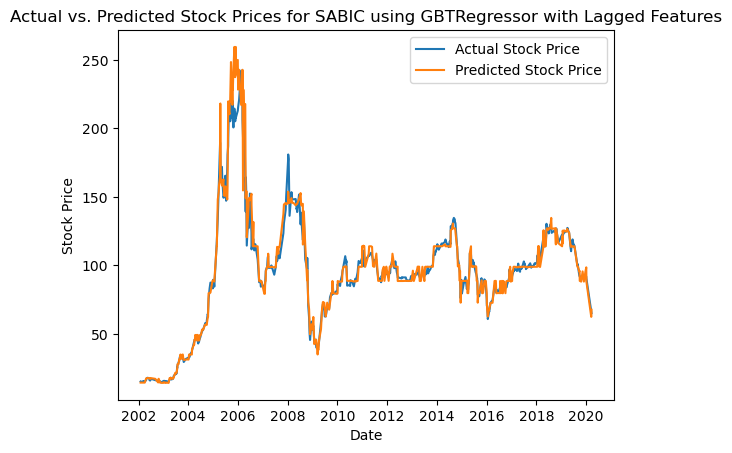

In [139]:
# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC using GBTRegressor with Lagged Features")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

24/05/06 21:50:48 WARN TaskSetManager: Stage 326934 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:50:48 WARN TaskSetManager: Stage 326937 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----------+-----------------+
|               Date|Stock_Price|       prediction|
+-------------------+-----------+-----------------+
|2008-02-06 00:00:00|      49.25| 53.6732244559265|
|2008-02-11 00:00:00|       46.0| 49.7747071543441|
|2008-02-12 00:00:00|       48.0|46.06748952709751|
|2008-02-13 00:00:00|      46.75| 49.7747071543441|
|2008-02-19 00:00:00|       48.0| 49.7747071543441|
|2008-02-20 00:00:00|      48.75| 49.7747071543441|
|2008-02-25 00:00:00|       49.5| 49.7747071543441|
|2008-02-26 00:00:00|       50.0| 49.7747071543441|
|2008-02-27 00:00:00|      51.25| 49.7747071543441|
|2008-03-03 00:00:00|       48.5|53.32587922542997|
|2008-03-04 00:00:00|      49.75| 49.7747071543441|
|2008-03-05 00:00:00|      49.25|49.42736192384757|
|2008-03-10 00:00:00|      47.75|49.34406731903092|
|2008-03-11 00:00:00|      49.25|49.34406731903092|
|2008-03-12 00:00:00|       49.0| 49.7747071543441|
|2008-03-17 00:00:00|       47.5|49.34406731903092|
|2008-03-18 

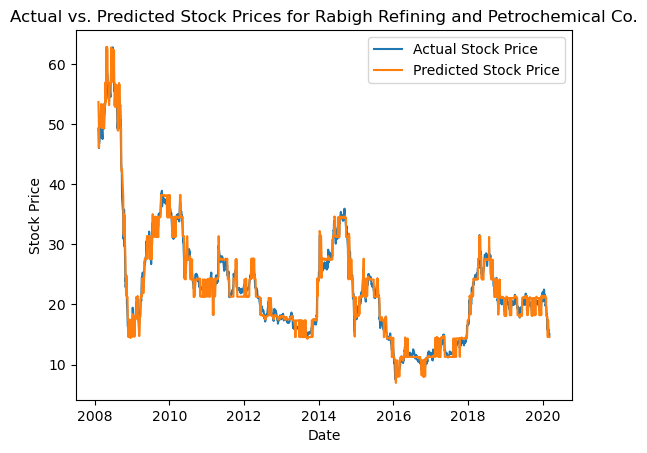

In [140]:
# show prediction vs actual stock price for Rabigh Refining and Petrochemical Co.
# get the predictions
predictions = model.transform(stocks_brent_gold_df_spark)

# select the relevant columns for Rabigh Refining and Petrochemical Co. stock prices
rabigh_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Rabigh Refining and Petrochemical Co.")

# display the actual and predicted stock prices for Rabigh Refining and Petrochemical Co.
rabigh_predictions.show()

# plot the actual and predicted stock prices for Rabigh Refining and Petrochemical Co.
sns.lineplot(data=rabigh_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=rabigh_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for Rabigh Refining and Petrochemical Co.")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [141]:
# print feature importances
feature_importances = model.featureImportances
feature_importances_df = pd.DataFrame(list(zip(["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], feature_importances)),
                                      columns=["Feature", "Importance"])
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)
print(feature_importances_df)

            Feature  Importance
3  Stock_Price_Lag1    0.818742
0    volume_traded     0.074433
1      value_traded    0.040106
9        Gold_Price    0.023631
8       Brent_Price    0.018843
2        no_trades     0.015135
5  Stock_Price_Lag3    0.003954
7  Stock_Price_Lag5    0.002512
4  Stock_Price_Lag2    0.002044
6  Stock_Price_Lag4    0.000600


# 2.4 Model Selection: SGD

Purpose: To optimize regression models efficiently for large datasets, suitable for high-dimensional spaces.

Features: Handles diverse features including continuous variables and time-series derivatives like lagged stock prices.

Methodology: Employs an iterative gradient descent algorithm to update parameters incrementally, optimizing the loss function effectively for scalability and speed.

In [142]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [143]:
# duplicate the label column to use it as a feature
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

In [144]:
# create lagged features for the stock price with window size of 5 considering the date and unique stock symbol
windowSpec = Window.partitionBy("name").orderBy("Date")
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag1", F.lag("Stock_Price", 1).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag2", F.lag("Stock_Price", 2).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag3", F.lag("Stock_Price", 3).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag4", F.lag("Stock_Price", 4).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag5", F.lag("Stock_Price", 5).over(windowSpec))

In [145]:
stocks_brent_gold_df_spark.show()

24/05/06 21:51:39 WARN TaskSetManager: Stage 326942 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|label|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-17 00:00:00| 12.6| 12.6| 12.3|       12.5|  -0.1|      -0.79|     9542486.0| 1.193622578E8|   11053.0|     112.92|    1675.5|

In [146]:
# drop the rows with missing values
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.dropna()

In [147]:
# create feature vector
vectorAssembler = VectorAssembler(inputCols=["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = vectorAssembler.transform(stocks_brent_gold_df_spark)

In [148]:
# view rows with missing values
stocks_brent_gold_df_spark.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stocks_brent_gold_df_spark.columns]).show()

24/05/06 21:51:45 WARN TaskSetManager: Stage 326945 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+--------+
|symbol|name|trading_name |Sector|Date|open|high|low|Stock_Price|change|perc_Change|volume_traded |value_traded|no_trades |Brent_Price|Gold_Price|label|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|features|
+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+--------+
|     0|   0|            0|     0|   0|   0|   0|  0|          0|     0|          0|             0|           0|         0|          0|         0|    0|               0|               0|               0|               0|               0|       0|
+------+----

In [149]:
# implement a Stochastic Gradient Descent - SGD
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the Stochastic Gradient Descent - SGD
from pyspark.ml.regression import GeneralizedLinearRegression
sgd = GeneralizedLinearRegression(featuresCol="features", labelCol="label")

# Train the model on the training data
model = sgd.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/05/06 21:51:49 WARN TaskSetManager: Stage 326951 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:51:49 WARN TaskSetManager: Stage 326952 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 21:51:49 WARN Instrumentation: [8f9de3e9] regParam is zero, which might cause numerical instability and overfitting.
24/05/06 21:51:49 WARN TaskSetManager: Stage 326956 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 1.9406754564131812


In [150]:
# print MSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse") 
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE):", mse)

24/05/06 21:51:52 WARN TaskSetManager: Stage 326960 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Mean Squared Error (MSE): 3.7662212271245092


In [151]:
# print SGD model hyperparameters
print(model._java_obj.getRegParam())


0.0


In [152]:
# print the accuracy of the model
predictions = model.transform(testData)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show(100)



24/05/06 21:52:02 WARN TaskSetManager: Stage 326964 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2002-01-09 00:00:00|      15.75|15.815938416056666|
|2002-01-14 00:00:00|      15.75|15.815131316639643|
|2002-01-15 00:00:00|      15.75| 15.81581477936956|
|2002-01-22 00:00:00|      15.25|15.793382371581625|
|2002-01-23 00:00:00|      15.25|15.328600646930639|
|2002-02-06 00:00:00|       15.0|15.067065761460315|
|2002-02-12 00:00:00|       15.0|15.078699038503949|
|2002-02-19 00:00:00|       14.5|14.546269250326457|
|2002-02-26 00:00:00|       14.5|14.571348802032828|
|2002-03-05 00:00:00|      14.75|14.577133637010984|
|2002-04-03 00:00:00|       15.5| 15.28752891401042|
|2002-04-04 00:00:00|       15.5|15.576325283922536|
|2002-04-18 00:00:00|      16.25|16.549109546921105|
|2002-04-22 00:00:00|      16.25|16.295498258280563|
|2002-05-07 00:00:00|      17.75|18.108983842285145|
|2002-05-09 00:00:00|      17.75|17.7931695992

24/05/06 21:52:05 WARN TaskSetManager: Stage 326967 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


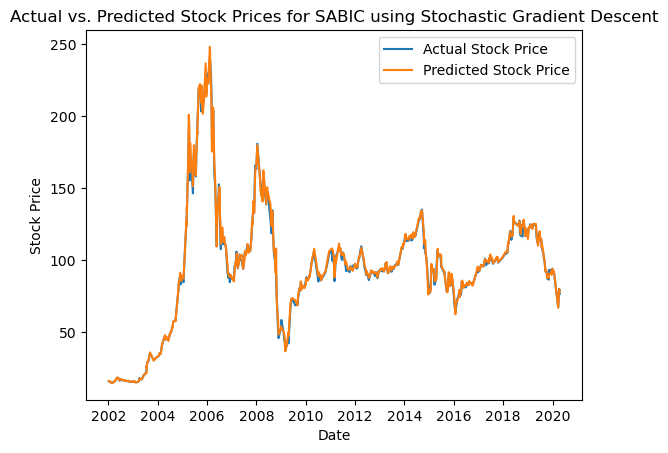

In [153]:
# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC using Stochastic Gradient Descent")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [155]:
# print hyperparameters of the SGD model
print(model._java_obj.getRegParam())
print(model._java_obj.getMaxIter())


0.0
25


In [167]:
# print the feature importances
feature_importances = model.coefficients
pd.options.display.float_format = '{:.10f}'.format
feature_importances_df = pd.DataFrame(list(zip(["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], feature_importances)),
                                      columns=["Feature", "Importance"])
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)
print(feature_importances_df)

            Feature    Importance
3  Stock_Price_Lag1  0.9968816417
4  Stock_Price_Lag2  0.0556232962
7  Stock_Price_Lag5  0.0123729481
8       Brent_Price  0.0016287664
2        no_trades   0.0000037455
1      value_traded  0.0000000025
0    volume_traded  -0.0000000451
9        Gold_Price -0.0000715500
6  Stock_Price_Lag4 -0.0219879217
5  Stock_Price_Lag3 -0.0493718219


In [172]:
# Stop the Spark session
spark.stop()